In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from math import *

import missingno as msno

import statsmodels.formula.api as smf
import statsmodels.api as sm

from scipy.cluster.hierarchy import dendrogram
import plotly.graph_objects as go

from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import SimpleImputer, IterativeImputer

import random

from unidecode import unidecode

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import usaddress

import pickle

# Ouverture et analyses de base

In [2]:
data = pd.read_csv('./data/2016_Building_Energy_Benchmarking.csv')

In [3]:
data.head(15)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.529300,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.816410,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.000000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.130860,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.984380,8803998.0,False,NaN,Compliant,NaN,505.01,2.88
5,9,2016,Nonresidential COS,Other,West Precinct,810 Virginia St,Seattle,WA,98101.0,0660000560,...,2.160444e+06,7371434.0,47151.816410,4715182.0,False,NaN,Compliant,NaN,301.81,3.10
6,10,2016,NonResidential,Hotel,Camlin,1619 9th Avenue,Seattle,WA,98101.0,0660000825,...,8.239199e+05,2811215.0,29475.800780,2947580.0,False,NaN,Compliant,NaN,176.14,2.12
7,11,2016,NonResidential,Other,Paramount Theatre,911 Pine St,Seattle,WA,98101.0,0660000955,...,1.065843e+06,3636655.0,3851.890137,385189.0,False,NaN,Compliant,NaN,221.51,2.16
8,12,2016,NonResidential,Hotel,311wh-Pioneer Square,612 2nd Ave,Seattle,WA,98104.0,0939000080,...,2.138898e+06,7297919.0,64259.000000,6425900.0,False,NaN,Compliant,NaN,392.16,2.39
9,13,2016,Multifamily MR (5-9),Mid-Rise Multifamily,Lyon Building,607 - 3rd Ave.,Seattle,WA,98104.0,0939000105,...,7.420912e+05,2532015.0,10020.259770,1002026.0,False,NaN,Compliant,NaN,151.12,2.37


In [4]:
print("Fichier de dimension " + str(data.shape) + " :\n")

print("\n\nType des colonnes :")
print(data.dtypes.to_markdown())

print("\n\nTaux de remplissage (%) :")
print(((1- data.isna().mean())*100).to_markdown())

print("\n\nNombre de valeurs uniques par colones :")
print(data.nunique().to_markdown())

Fichier de dimension (3376, 46) :



Type des colonnes :
|                                 | 0       |
|:--------------------------------|:--------|
| OSEBuildingID                   | int64   |
| DataYear                        | int64   |
| BuildingType                    | object  |
| PrimaryPropertyType             | object  |
| PropertyName                    | object  |
| Address                         | object  |
| City                            | object  |
| State                           | object  |
| ZipCode                         | float64 |
| TaxParcelIdentificationNumber   | object  |
| CouncilDistrictCode             | int64   |
| Neighborhood                    | object  |
| Latitude                        | float64 |
| Longitude                       | float64 |
| YearBuilt                       | int64   |
| NumberofBuildings               | float64 |
| NumberofFloors                  | int64   |
| PropertyGFATotal                | int64   |
| PropertyGFAParking   

<AxesSubplot: >

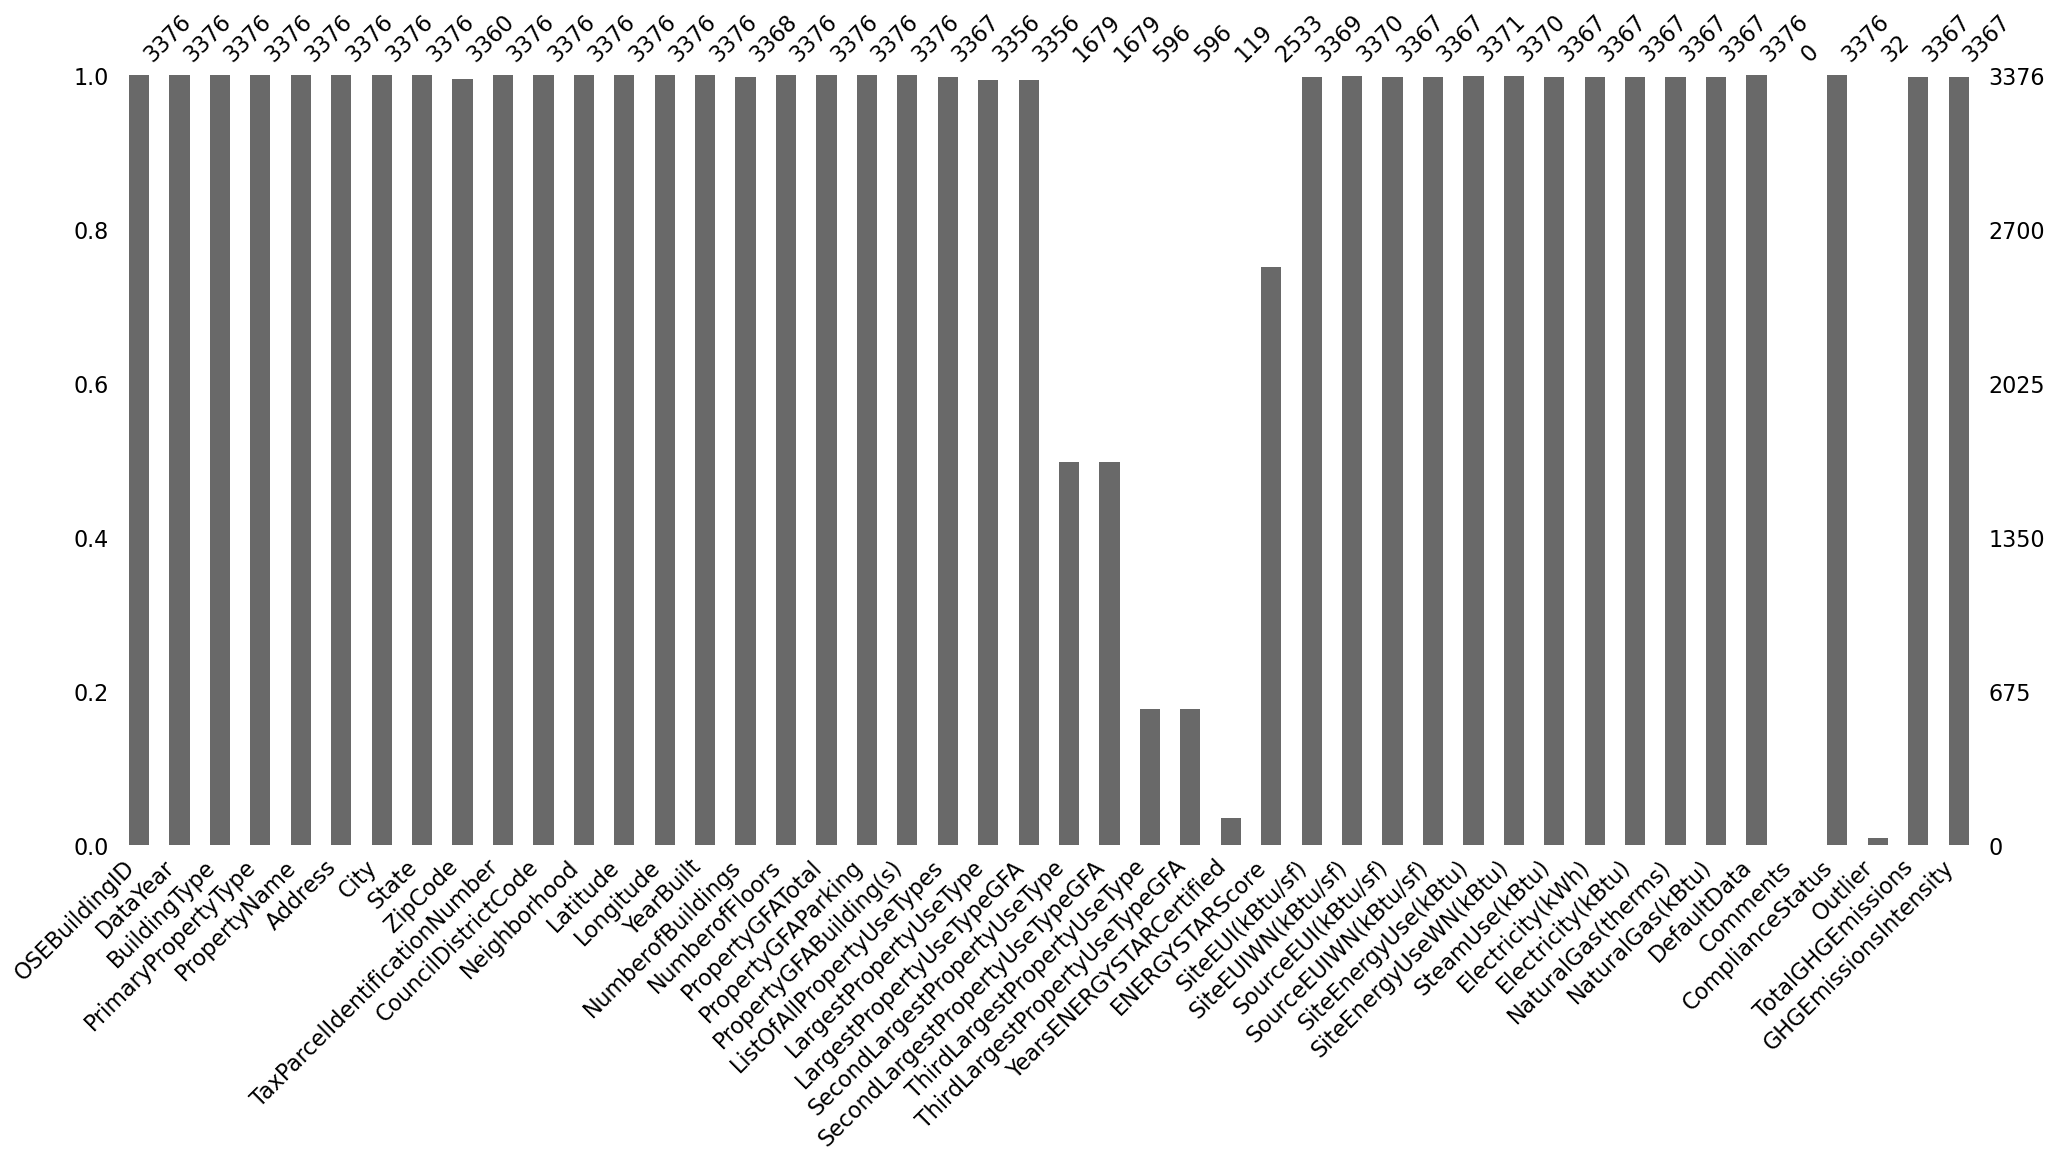

In [5]:
msno.bar(data)

### Descriptions interactives

In [6]:
@interact
def show_describe(column=list(data.columns)):
    return data[column].describe().T

interactive(children=(Dropdown(description='column', options=('OSEBuildingID', 'DataYear', 'BuildingType', 'Pr…

In [7]:
@interact
def show_extract(column=list(data.columns), x=(0, 300, 1)):
    tmp = data.loc[~data[column].isna(), column]
    return tmp.iloc[x:x+10]

interactive(children=(Dropdown(description='column', options=('OSEBuildingID', 'DataYear', 'BuildingType', 'Pr…

In [8]:
@interact
def show_extract(column=list(data.columns)):
    tmp = data[column].value_counts()
    print(len(tmp))
    return data[column].value_counts().iloc[:20]

interactive(children=(Dropdown(description='column', options=('OSEBuildingID', 'DataYear', 'BuildingType', 'Pr…

# Mise en forme du dataset

In [9]:
t = ('int64', 'discrete', 'continue', 'nominal', 'ordinal')

In [10]:
for c in ['ZipCode', 'NumberofBuildings', 'LargestPropertyUseTypeGFA', 
          'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']:
    data[c] = data[c].astype('int64', errors='ignore')

In [11]:
COL = {'OSEBuildingID': ('string', 'nominal'),
       'DataYear':('int64', 'discrete'),
       'BuildingType':('category', ('string', 'nominal')),
       'PrimaryPropertyType':('category', ('string', 'nominal')),
       'PropertyName':('string', 'nominal'),
       'Address':('string', 'nominal'),
       'City':('category', ('string', 'nominal')),
       'State':('category', ('string', 'nominal')),
       'ZipCode':('category', ('string', 'nominal')),
       'TaxParcelIdentificationNumber':('string', 'nominal'),
       'CouncilDistrictCode':('category', ('string', 'nominal')),
       'Neighborhood':('category', ('string', 'nominal')),
       'Latitude':('float32', 'continue'),
       'Longitude':('float32', 'continue'),
       'YearBuilt':('int64', 'discrete'),
       'NumberofBuildings':('int64', 'discrete'),
       'NumberofFloors':('int64', 'discrete'),
       'PropertyGFATotal':('int64', 'discrete'),
       'PropertyGFAParking':('int64', 'discrete'),
       'PropertyGFABuilding(s)':('int64', 'discrete'),
       'ListOfAllPropertyUseTypes':('category', ('string', 'nominal')),
       'LargestPropertyUseType':('category', ('string', 'nominal')),
       'LargestPropertyUseTypeGFA':('int64', 'discrete'),
       'SecondLargestPropertyUseType':('category', ('string', 'nominal')),
       'SecondLargestPropertyUseTypeGFA':('int64', 'discrete'),
       'ThirdLargestPropertyUseType':('category', ('string', 'nominal')),
       'ThirdLargestPropertyUseTypeGFA':('int64', 'discrete'),
       'YearsENERGYSTARCertified':('string', 'nominal'),
       'ENERGYSTARScore':('float32', 'continue'),
       'SiteEUI(kBtu/sf)':('float32', 'continue'),
       'SiteEUIWN(kBtu/sf)':('float32', 'continue'),
       'SourceEUI(kBtu/sf)':('float32', 'continue'),
       'SourceEUIWN(kBtu/sf)':('float32', 'continue'),
       'SiteEnergyUse(kBtu)':('float32', 'continue'),
       'SiteEnergyUseWN(kBtu)':('float32', 'continue'),
       'SteamUse(kBtu)':('float32', 'continue'),
       'Electricity(kWh)':('float32', 'continue'),
       'Electricity(kBtu)':('float32', 'continue'),
       'NaturalGas(therms)':('float32', 'continue'),
       'NaturalGas(kBtu)':('float32', 'continue'),
       'DefaultData':('boolean', 'nominal'),
       'Comments':('string', 'nominal'),
       'ComplianceStatus':('category', ('string', 'nominal')),
       'Outlier':('category', ('string', 'nominal')),
       'TotalGHGEmissions':('float32', 'continue'),
       'GHGEmissionsIntensity':('float32', 'continue')}

## Formatage de toutes les colonnes
### Changement du type

In [12]:
for c, e in COL.items():
    t, o = e
    if t == 'category':
        t, o = o
        data[c] = data[c].astype(t, errors='ignore')
        if t == 'string':
            data[c] = data[c].str.capitalize()
        data[c] = data[c].astype('category', errors='ignore')
    else:
        data[c] = data[c].astype(t, errors='ignore')
        if t == 'string':
            data[c] = data[c].str.capitalize()

## Créations de listes utiles

In [13]:
# Liste des colonnes à prédire (et leur nouveau nom)
col_Y =  ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']
col_Y_rename = ['Energy', 'CO2']

# Liste des colonnes à ne pas utiliser car faisant partie des relevés
col_interdit = ['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
                'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', #'Outlier',
                'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'DefaultData', 'Comments',
                'ComplianceStatus', 'GHGEmissionsIntensity']

col_inutile = ['DataYear', 'ListOfAllPropertyUseTypes', 'City', 'State', 'TaxParcelIdentificationNumber',
               'ListOfAllPropertyUseTypes', 'YearsENERGYSTARCertified']

In [14]:
def update_col(data, out=True):
    global col_nan, col_autorise, col_num, col_cat
    
    # Liste des colonnes avec plus de 50% de NaN
    col_nan = data.columns[data.isna().sum() > len(data)/2].to_list()

    # Inverse de la liste col_interdit et col_nan
    col_autorise = [e for e in data.columns if e not in col_interdit+col_nan+col_inutile]

    if out:
        #Ajout temperaire pour vérifier les outliers
        col_autorise += ['Outlier']

    # Liste des colonnes numeriques
    col_num = data[col_autorise].select_dtypes(include=['float', 'int']).columns.to_list()

    # Liste des colonnes categorielles
    col_cat = data[col_autorise].select_dtypes(include=['category']).columns.to_list()

In [15]:
update_col(data)

## Modification des valeurs
### Gestion des outliers

In [16]:
# Affichage des outliers selon les quantilles

@interact
def regarder_outliers(col = col_num):
    return data.loc[data[col] > data[col].mean() + 3 * data[col].std(), col_autorise].T

interactive(children=(Dropdown(description='col', options=('Latitude', 'Longitude', 'YearBuilt', 'NumberofBuil…

In [17]:
# Affichage des 5 valeurs les plus hautes

@interact
def regarder_outliers(col = col_num):
    return data.loc[data[col].sort_values(ascending=False).index[:5], col_autorise].T

interactive(children=(Dropdown(description='col', options=('Latitude', 'Longitude', 'YearBuilt', 'NumberofBuil…

In [18]:
# Modification des erreurs
data.loc[data['OSEBuildingID']=='21611', 'NumberofFloors'] = 1

### Remplacement des NaN

In [19]:
data['LargestPropertyUseType'] = data['LargestPropertyUseType'].cat.add_categories('').fillna('')
data['SecondLargestPropertyUseType'] = data['SecondLargestPropertyUseType'].cat.add_categories('').fillna('')
data['ThirdLargestPropertyUseType'] = data['ThirdLargestPropertyUseType'].cat.add_categories('').fillna('')

In [20]:
data['LargestPropertyUseType'] = data['LargestPropertyUseType'].fillna(0)
data['SecondLargestPropertyUseTypeGFA'] = data['SecondLargestPropertyUseTypeGFA'].fillna(0)
data['ThirdLargestPropertyUseTypeGFA'] = data['ThirdLargestPropertyUseTypeGFA'].fillna(0)

### Création de nouvelles colonnes

In [21]:
# Colonnes de présence de certaines energies (puis conversion numerique)
data[['Steam', 'Electricity', 'Gas']] = data[['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']] > 0
data[['Steam', 'Electricity', 'Gas']] = data[['Steam', 'Electricity', 'Gas']].replace({True: 1, False: 0})
data[['Steam', 'Electricity', 'Gas']] = data[['Steam', 'Electricity', 'Gas']].astype('int', errors='ignore')

In [22]:
# Fonction pour ne retourner qu'une partie de l'addresse (enleve le numero)
def extract_street(address):
    # Parser l'adresse
    parsed_address = usaddress.parse(address)
    
    street = ""
    
    # Boucle à travers les composants de l'adresse pour trouver la rue
    for component in parsed_address:
        #if 'StreetName' in component[1]:
        if component[1] in ['StreetName', 'StreetNamePostType']:
            street += ' ' + component[0]
    street = street.replace('.', '')[1:]
    return street

In [23]:
# Colonne d'adresse plus simple (sans position ou numero)
data['SimpleAddress'] = data['Address'].apply(extract_street)
data['SimpleAddress'] = data['SimpleAddress'].astype('string', errors='ignore').astype('category', errors='ignore')

In [24]:
# Nombre d'usages de la parcelle
data['NumberOfPropertyUseTypes'] = data['ListOfAllPropertyUseTypes'].str.count(',') + 1

In [25]:
# Volume de surface entre 4 murs et un plafond 
data['SurfaceInside'] = data['PropertyGFABuilding(s)'] * data['NumberofFloors']

In [26]:
# Viellesse
data['Age'] = 2023 - data['YearBuilt']

In [27]:
# Proximité à l'équateur (sin ?) [0 pole nord, 1 equateur]
data['EquatorProximity'] = (90 - data['Latitude'].abs())/90

In [28]:
from sklearn.neighbors import KNeighborsRegressor

In [29]:
with open('./data/dist_model.plk', 'rb') as f:
    neigh = pickle.load(f)

In [30]:
data['SeaProximity'] = neigh.predict(data[['Longitude', 'Latitude']])
data['SeaProximityLog'] = data['SeaProximity'].apply(lambda x: log(x+1))

In [31]:
with open('./data/dist_model_limit.plk', 'rb') as f:
    neigh = pickle.load(f)

data['SeaProximityLimit'] = neigh.predict(data[['Longitude', 'Latitude']])
data['SeaProximityLogLimit'] = data['SeaProximityLimit'].apply(lambda x: log(x+1))

In [32]:
# Type de propriété selon PropertyName
# Extraire le dernier mot de PropertyName (enlever entre (), trim etc...)

In [33]:
# Categories simplifies
# surface fermee, surface fermee pour humains, surface fermee pour stockage/machines, surface ouvertes
# calculer volume avec etages * surfac

In [34]:
# tmp = data['ListOfAllPropertyUseTypes'].str.replace(r'\(.+\)', '', regex=True).str.split(', ').explode()
# print(tmp.str.capitalize().value_counts().to_markdown())

## Conversion des categories

In [35]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder

In [36]:
update_col(data, out=False)

In [37]:
data[col_cat].isna().sum()

BuildingType                     0
PrimaryPropertyType              0
ZipCode                         16
CouncilDistrictCode              0
Neighborhood                     0
LargestPropertyUseType           0
SecondLargestPropertyUseType     0
ThirdLargestPropertyUseType      0
SimpleAddress                    0
dtype: int64

In [38]:
# data.loc[data['ZipCode'].isna(), ['OSEBuildingID', 'Address']]

In [39]:
fill_zipcode = [('50196', '98109'), ('50198', '98144'), ('50201', '98117'), ('50204', '98125'),
               ('50207', '98107'), ('50208', '98117'), ('50210', '98103'), ('50212', '98112'),
               ('50219', '98122'), ('50220', '98118'), ('50221', '98126'), ('50222', '98108'),
               ('50223', '98104'), ('50224', '98119'), ('50225', '98109'), ('50226', '98108')]

for i, z in fill_zipcode:
    if z not in data['ZipCode'].cat.categories:
        data['ZipCode'] = data['ZipCode'].cat.add_categories([z])
    
    data.loc[data['OSEBuildingID']==i, 'ZipCode'] = z

data['ZipCode'] = data['ZipCode'].cat.add_categories('').fillna('')

In [40]:
data[col_cat] = OrdinalEncoder().fit_transform(data[col_cat])

# Export des données

In [41]:
data = data.sample(frac=1)

In [42]:
update_col(data, out=False)

In [43]:
data_X_star = data[col_autorise].copy().dropna()
data_X = data[[e for e in col_autorise if e != 'ENERGYSTARScore']].copy().dropna()

data_Y_star = pd.DataFrame()
data_Y = pd.DataFrame()

data_Y_star[col_Y_rename] = data_X_star[col_Y].copy()
data_Y[col_Y_rename] = data_X[col_Y].copy()

data_X_star = data_X_star.drop(col_Y, axis=1)
data_X = data_X.drop(col_Y, axis=1)

In [44]:
with open("./data/pickle", 'wb') as f:
    pickle.dump(([data_X, data_X_star], [data_Y, data_Y_star]), f)

# Visualisation

In [45]:
@interact
def show_extract(column=list(data.select_dtypes(include=['category', 'int']).columns)):
    tmp = data[column].value_counts().iloc[:30]

    plt.barh(list(tmp.index), tmp.values)

    plt.title("Nombre d'occurences pour {}".format(column))
    plt.ylabel("Nombre d'occurences")

    plt.show()

interactive(children=(Dropdown(description='column', options=('DataYear', 'City', 'State', 'YearBuilt', 'Numbe…

In [46]:
data.select_dtypes(include=['float', 'int'])

,DataYear,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,...,Gas,SimpleAddress,NumberOfPropertyUseTypes,SurfaceInside,Age,EquatorProximity,SeaProximity,SeaProximityLog,SeaProximityLimit,SeaProximityLogLimit
743,2016,2.0,7.0,30.0,0.0,13.0,47.585701,-122.397911,1973,1.0,...,1,249.0,1.0,107520,50,0.471270,0.191113,0.174888,0.191113,0.174888
27,2016,4.0,3.0,10.0,6.0,4.0,47.617840,-122.329659,2001,1.0,...,1,723.0,1.0,1335850,22,0.470913,1.128647,0.755486,1.453038,0.897327
2593,2016,4.0,19.0,23.0,6.0,7.0,47.622978,-122.330818,1912,1.0,...,1,618.0,2.0,55576,111,0.470856,0.520805,0.419240,1.867701,1.053511
1236,2016,2.0,7.0,10.0,6.0,4.0,47.609058,-122.337570,1907,1.0,...,1,125.0,1.0,81750,116,0.471010,0.446638,0.369242,0.388497,0.328222
2665,2016,2.0,7.0,16.0,3.0,10.0,47.668159,-122.313408,1997,1.0,...,1,691.0,2.0,132724,26,0.470354,1.705571,0.995313,1.951272,1.082236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3050,2016,2.0,7.0,48.0,0.0,13.0,47.540051,-122.395027,1963,1.0,...,0,494.0,2.0,91936,60,0.471777,0.181464,0.166754,0.181464,0.166754
73,2016,5.0,12.0,23.0,6.0,8.0,47.623951,-122.350769,1962,1.0,...,0,533.0,1.0,104000,61,0.470845,0.999010,0.692652,0.999010,0.692652
2441,2016,4.0,19.0,15.0,6.0,4.0,47.600712,-122.333771,1909,0.0,...,1,64.0,2.0,141645,114,0.471103,0.402298,0.338112,0.443764,0.367254
2497,2016,1.0,1.0,15.0,2.0,5.0,47.610611,-122.323669,1929,1.0,...,1,650.0,1.0,803088,94,0.470993,1.529379,0.927974,1.519229,0.923953


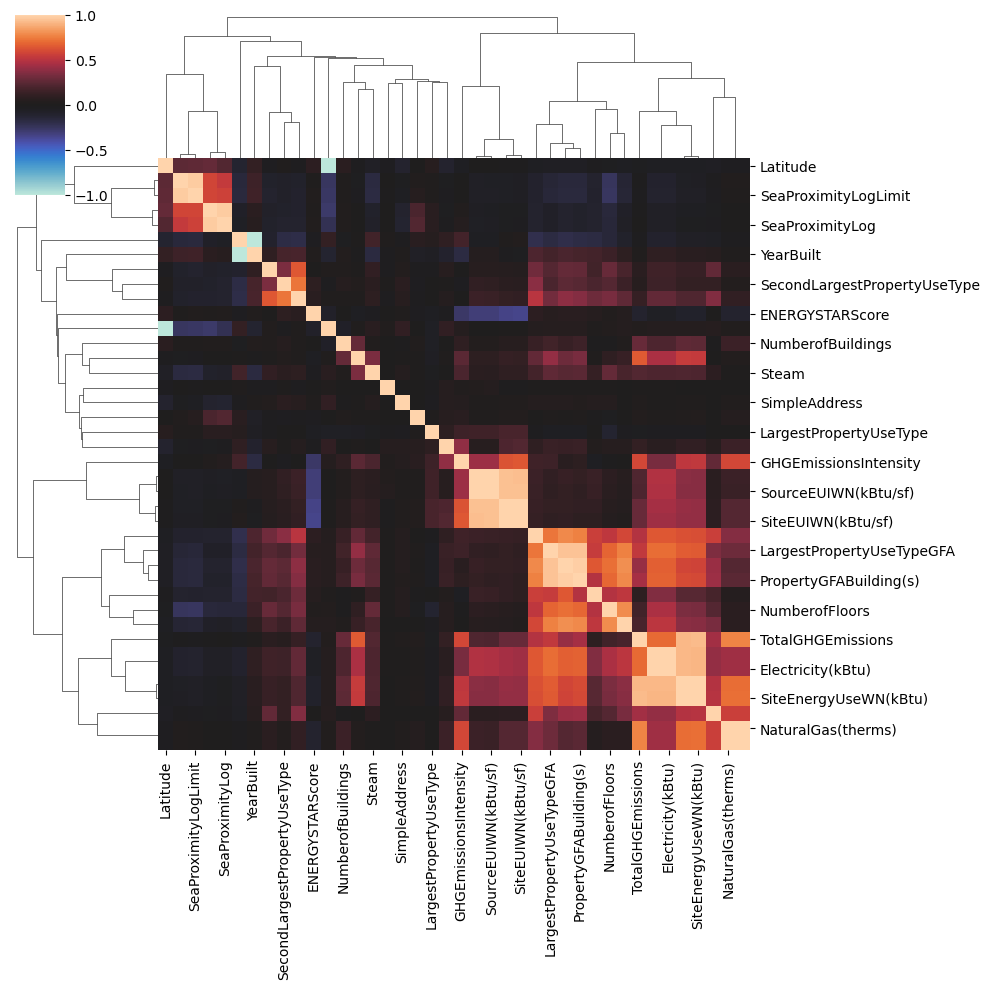

In [47]:
dataTmp = data.loc[:, 'Latitude':].select_dtypes(include=['float', 'int']).dropna().corr()
h = sns.clustermap(dataTmp, vmin=-1, vmax=1, center=0)

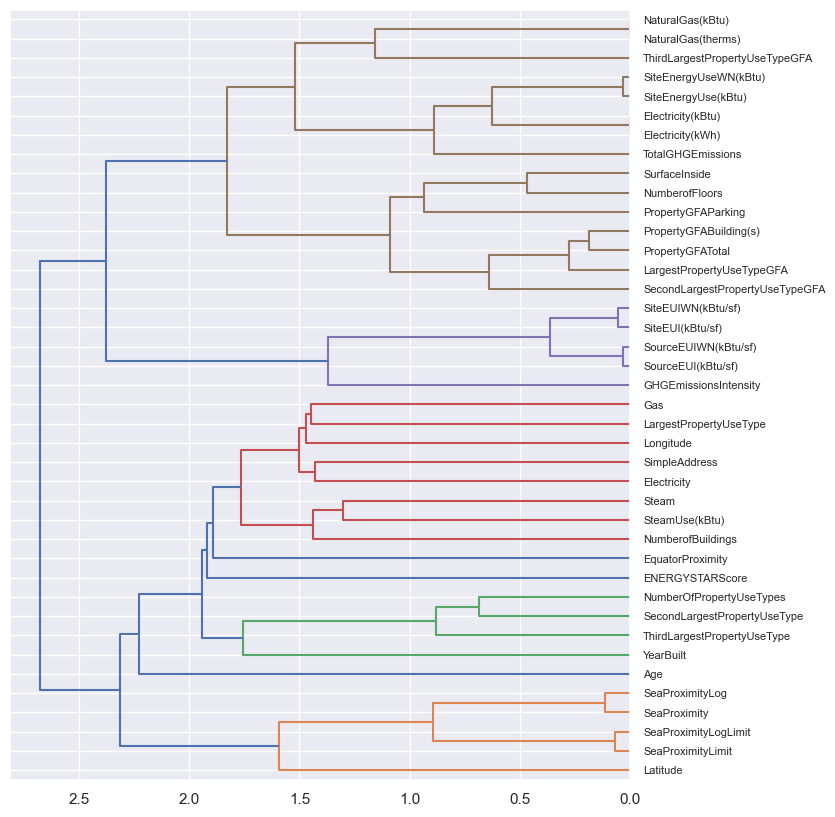

In [48]:
sns.set(rc={"figure.figsize":(8, 10)})
dendrogram(h.dendrogram_col.linkage, labels=dataTmp.columns, orientation='left');

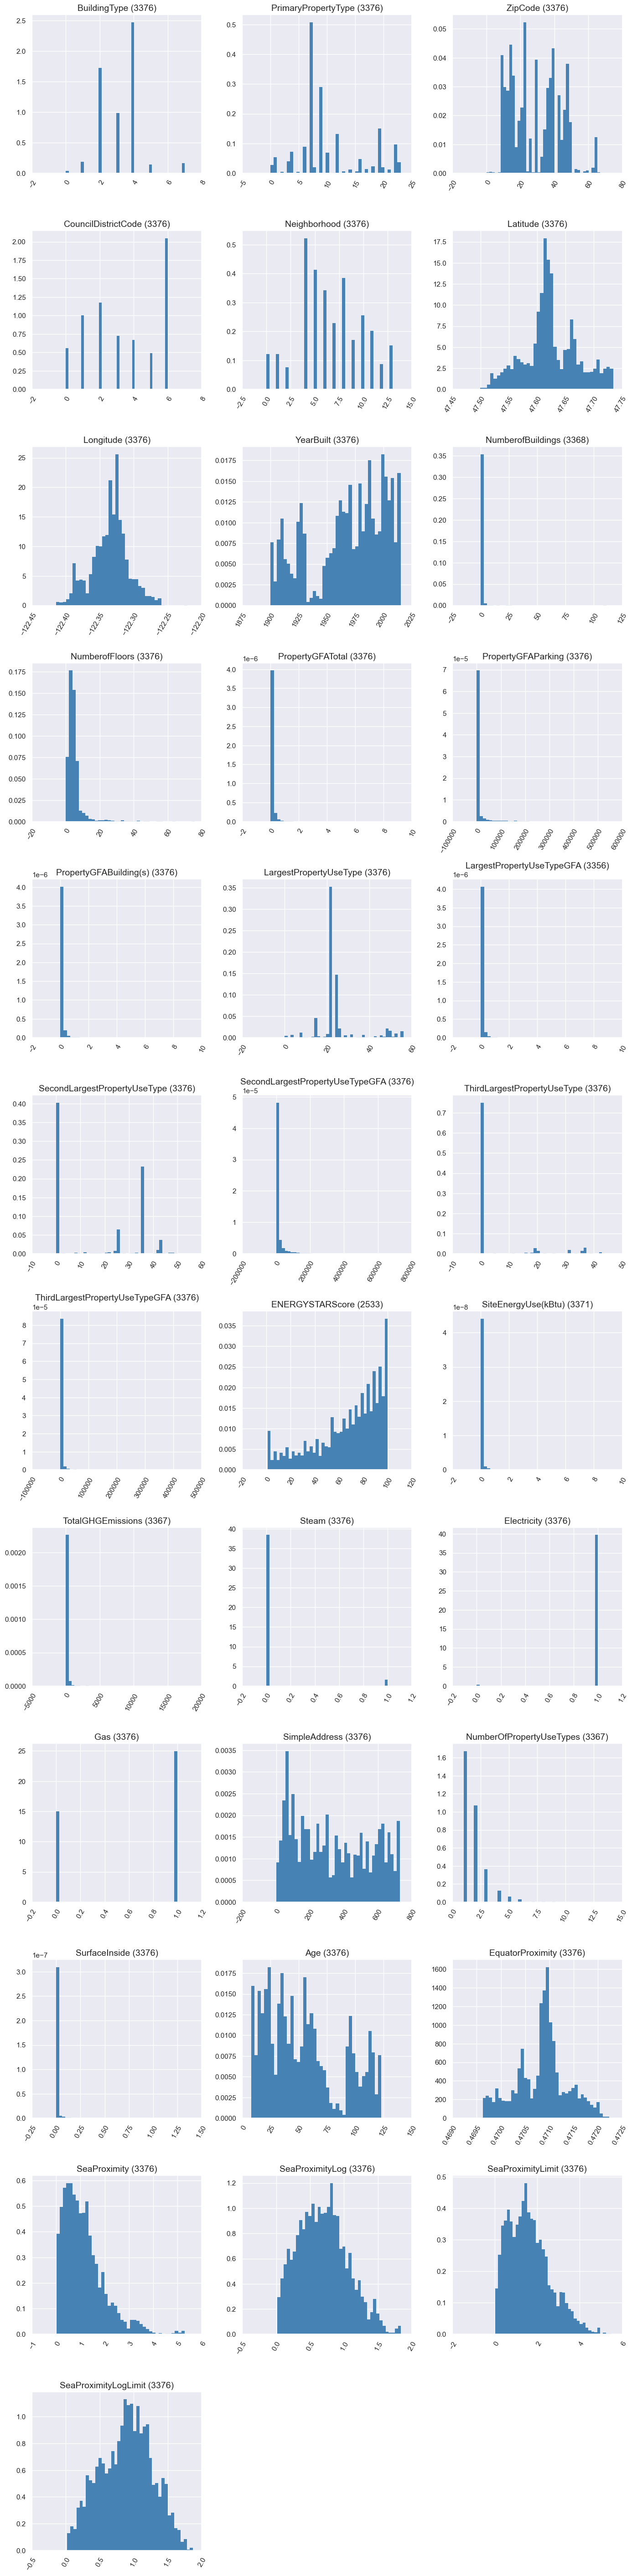

In [49]:
lTmp = list(data[col_autorise].select_dtypes(include=['category', 'int', 'float']).columns)
tTmp = len(lTmp)

fig = plt.figure(figsize=(14,  5 * tTmp/3))

for feat_idx in range(tTmp):
    ax = fig.add_subplot((2+tTmp)//3, 3, (feat_idx+1))
    
    tmp = data[lTmp[feat_idx]].dropna().copy()
    if tmp.dtype == 'category':
        tmp = tmp.loc[tmp.isin(tmp.value_counts()[:20].index)]
    
    h = ax.hist(tmp, bins=40, color='steelblue', density=True, edgecolor='none')
    ax.set_title("{} ({})".format(lTmp[feat_idx], len(tmp)), fontsize=14)
    ax.set_xticks(ax.get_xticks(), [x.get_text()[:20] for x in ax.get_xticklabels()], rotation=60, ha='right', rotation_mode='anchor')

fig.tight_layout(pad=1)
plt.show()

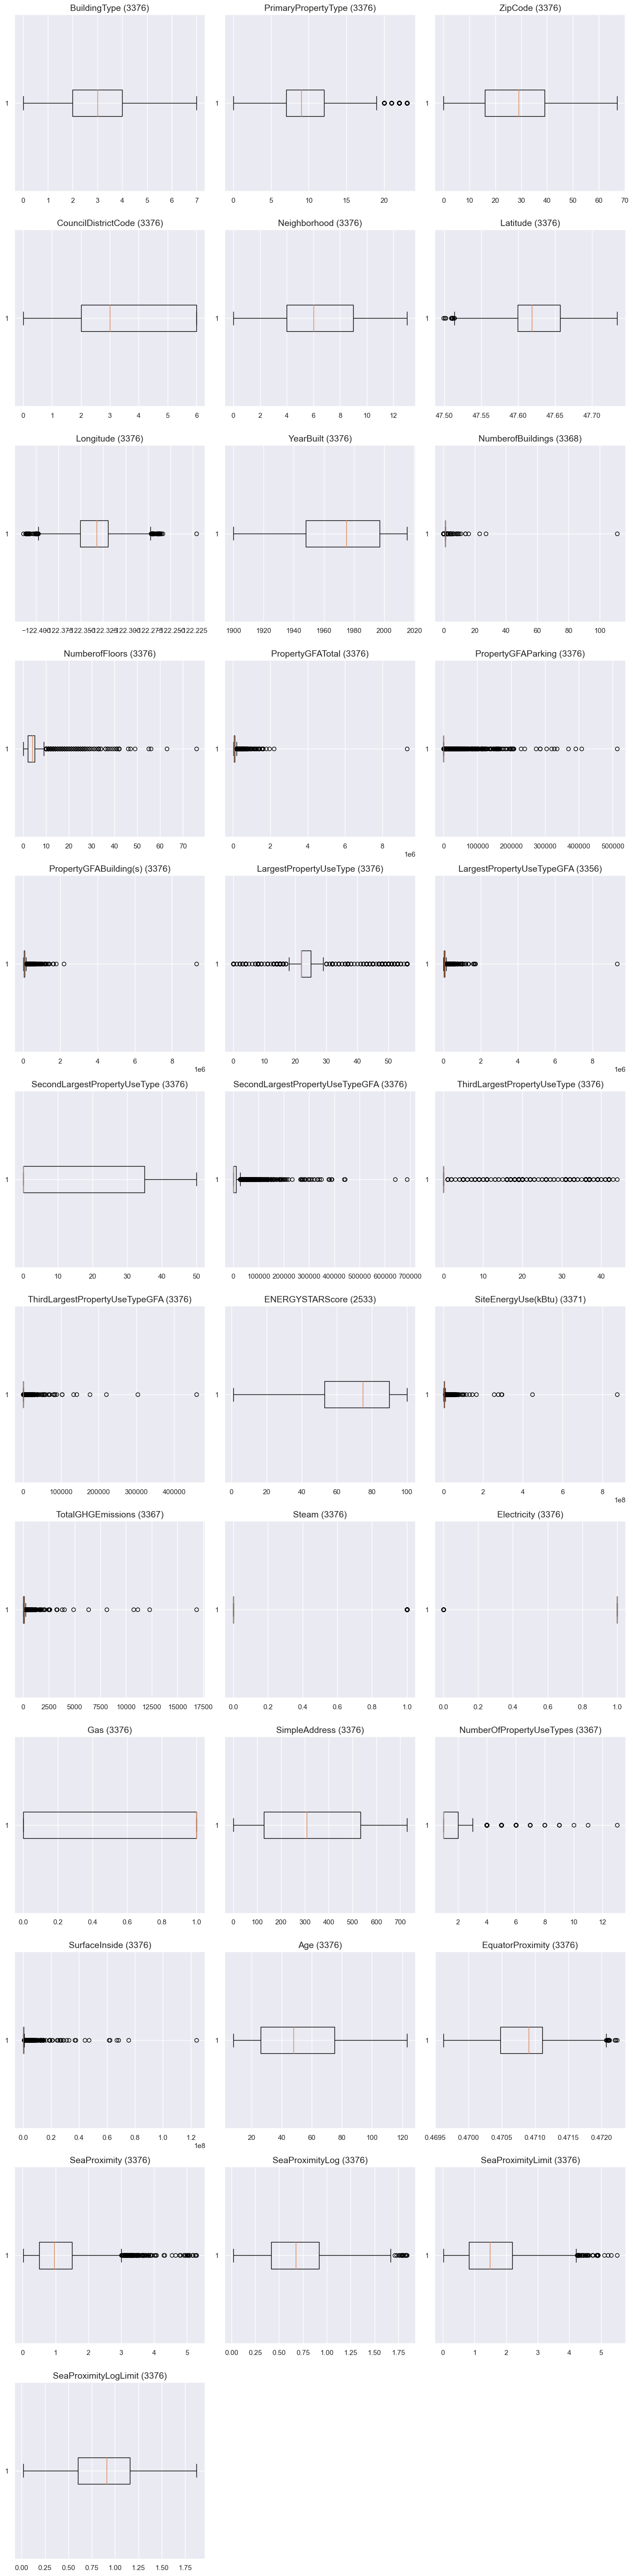

In [50]:
lTmp = list(data[col_autorise].select_dtypes(include=['int', 'float']).columns)
tTmp = len(lTmp)

fig = plt.figure(figsize=(14,  5 * tTmp/3))

for feat_idx in range(tTmp):
    ax = fig.add_subplot((2+tTmp)//3, 3, (feat_idx+1))
    
    tmp = data[lTmp[feat_idx]].dropna().copy()
    if tmp.dtype == 'category':
        tmp = tmp.loc[tmp.isin(tmp.value_counts()[:20].index)]
    
    h = ax.boxplot(tmp, vert=False)
    ax.set_title("{} ({})".format(lTmp[feat_idx], len(tmp)), fontsize=14)
    
fig.tight_layout(pad=1)
plt.show()

In [51]:
from math import *
from matplotlib.colors import LogNorm

In [52]:
sns.set(rc={"figure.figsize":(8, 6)})

@interact
def show_articles_more_than(couleur=data.select_dtypes(include=['int', 'float']).columns):
    x = data["Longitude"]
    y = data["Latitude"]

    c = data[couleur]

    fig = plt.figure()
    ax = plt.axes()
    
    if couleur in ['NumberofFloors', 'NumberofBuildings', 'SurfaceInside'] or '(' in couleur:
        sc = ax.scatter(x, y, c=c, s=0, alpha=1, norm=LogNorm())
        ax.scatter(x, y, c=c, s=50, alpha=0.2, norm=LogNorm())
    else:
        sc = ax.scatter(x, y, c=c, s=0, alpha=1)
        ax.scatter(x, y, c=c, s=50, alpha=0.2)
        


    cb = fig.colorbar(sc, ax=ax)
    
    plt.show()

interactive(children=(Dropdown(description='couleur', options=('DataYear', 'BuildingType', 'PrimaryPropertyTyp…